In [ ]:
#!pip install xgboost

In [2]:
# Импорт необходимых библиотек
import pandas as pd
from process_func import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from xgboost import XGBClassifier
#import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [3]:
with open('data/train.json', 'r') as file:
    train = json.load(file)

In [4]:
with open('data/val.json', 'r') as file:
    val = json.load(file)

In [5]:
with open('data/test.json', 'r') as file:
    test = json.load(file)

In [6]:
with open('data/general_categories_mapping.json', 'r', encoding='utf-8') as file:
    cat_map = json.load(file)

In [7]:
# Создание списка всех категорий для словаря векторизатора
all_categories = [str(category) for category in set(cat_map.values())]

In [8]:
categories_df = pd.DataFrame(all_categories, columns=['Category'])
# Сохранение в файл CSV уникальных категорий товаров
categories_df.to_csv('cats/categories.csv', index=False)

In [8]:
merge_df_train = get_df(train)
merge_df_train.head()

,user_id,order_site-id_count,order_orders_mean,order_items_mean,order_items_count_mean,order_cats,order_brands,visit_site-id_count,visit_visits_mean,visit_items_mean,...,visit_pages_mean,site_site-id_count,site_recency_mean,site_frequency_mean,site_monetary_mean,exchange_sessions_count,exchange_clicks_mean,exchange_accepted_mean,last_cats,target
0,user_1,2.0,1.5,0.0,0.0,{},{},NaN,NaN,NaN,...,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,female
1,user_2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,...,1.5,9.0,0.0,0.0,0.0,NaN,NaN,NaN,{other},female
2,user_3,2.0,1.0,0.5,1.0,{},{},3.0,4.7,0.6,...,4.6,9.0,0.7,0.2,1.1,NaN,NaN,NaN,"{electronics, other}",male
3,user_4,4.0,2.0,0.5,1.0,"{7330336, 90402, 90403, 90404, 90692, 8353924,...","{1210537, 3243, 1773}",6.0,2.8,0.1,...,3.2,14.0,0.3,0.4,0.7,NaN,NaN,NaN,"{hypermarket, education, other}",male
4,user_5,3.0,1.0,1.7,1.0,"{91072, 90402, 91491, 91461, 13199877, 198119,...","{1, 1161, 4315}",5.0,4.6,1.1,...,5.4,15.0,0.2,0.2,1.0,NaN,NaN,NaN,"{health, pets, insurance, cosmetics, bank, ent...",female


In [9]:
# Функция для замены специфической строки в множестве на 'fashion'
def replace_in_set(cat_set):
    if '"0" => "f", "1" => "a", "2" => "s", "3" => "h", "4" => "i", "5" => "o", "6" => "n"' in cat_set:
        cat_set.remove('"0" => "f", "1" => "a", "2" => "s", "3" => "h", "4" => "i", "5" => "o", "6" => "n"')
        cat_set.add('fashion')
    return cat_set

In [10]:
# Применение функции замены к каждой строке в столбце 'last_cats'
merge_df_train['last_cats'] = merge_df_train['last_cats'].apply(lambda x: x if x is not np.nan else set())
merge_df_train['last_cats'] = merge_df_train['last_cats'].apply(replace_in_set)

In [11]:
merge_df_train[merge_df_train['last_cats'].astype(str).str.\
               contains('"0" => "f", "1" => "a", "2" => "s", "3" => "h", "4" => "i", "5" => "o", "6" => "n"')]

,user_id,order_site-id_count,order_orders_mean,order_items_mean,order_items_count_mean,order_cats,order_brands,visit_site-id_count,visit_visits_mean,visit_items_mean,...,visit_pages_mean,site_site-id_count,site_recency_mean,site_frequency_mean,site_monetary_mean,exchange_sessions_count,exchange_clicks_mean,exchange_accepted_mean,last_cats,target


In [12]:
# last_cats
unique_last_cats = set()
for cats in merge_df_train['last_cats']:
    unique_last_cats.update(cats)
unique_last_cats = list(unique_last_cats)

In [13]:
last_categories_df = pd.DataFrame(unique_last_cats, columns=['Category'])
# Сохранение в файл CSV уникальных last категорий товаров
last_categories_df.to_csv('cats/last_categories.csv', index=False)

In [13]:
merge_df_val = get_df(val)
merge_df_val.head()

,user_id,order_site-id_count,order_orders_mean,order_items_mean,order_items_count_mean,order_cats,order_brands,visit_site-id_count,visit_visits_mean,visit_items_mean,...,visit_pages_mean,site_site-id_count,site_recency_mean,site_frequency_mean,site_monetary_mean,exchange_sessions_count,exchange_clicks_mean,exchange_accepted_mean,last_cats,target
0,user_127756,1.0,1.0,1.0,0.0,{},{},2.0,6.0,0.0,...,1.6,1,0.0,0.0,0.0,2.0,0.0,1.0,"{education, other}",female
1,user_127757,4.0,3.5,1.0,1.0,"{90625, 90629, 7330336, 12644137, 90666, 12644...","{1, 996, 3519, 1650, 1237, 1055}",3.0,1.0,0.3,...,4.0,5,0.6,1.6,2.8,1.0,1.0,1.0,"{shoes, electronics, other}",male
2,user_127758,5.0,1.4,5.4,2.0,"{90509, 15753361, 15753363, 91284, 91157, 1473...","{6275, 17416, 62479, 16915, 13337, 16667, 5508...",15.0,3.5,0.7,...,4.4,14,0.6,0.5,0.6,NaN,NaN,NaN,"{gifts, luxury, household_appliances, pets, fu...",female
3,user_127759,3.0,3.3,5.2,1.0,"{90509, 91157, 8475933, 91176, 90666, 91182, 4...","{3192, 7066, 3860}",9.0,3.9,0.7,...,2.7,8,1.1,0.5,1.8,4.0,0.5,0.5,"{gifts, health, furniture, cosmetics, hypermar...",female
4,user_127760,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.5,0.3,...,18.3,8,0.0,0.0,0.0,NaN,NaN,NaN,"{other, cosmetics}",female


In [14]:
merge_df_test = get_df(test, target=False)
merge_df_test.head()

,user_id,order_site-id_count,order_orders_mean,order_items_mean,order_items_count_mean,order_cats,order_brands,visit_site-id_count,visit_visits_mean,visit_items_mean,...,visit_duration_mean,visit_pages_mean,site_site-id_count,site_recency_mean,site_frequency_mean,site_monetary_mean,exchange_sessions_count,exchange_clicks_mean,exchange_accepted_mean,last_cats
0,user_155203,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.7,0.2,...,163.6,2.8,5.0,0.0,0.0,0.0,1.0,1.0,1.0,"{cosmetics, media, hypermarket, electronics, o..."
1,user_155204,1.0,1.0,0.0,0.0,{},{},10.0,4.0,0.1,...,54.7,1.6,6.0,0.0,0.0,0.0,NaN,NaN,NaN,"{household_appliances, furniture, insurance, b..."
2,user_155205,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,{other}
3,user_155206,3.0,3.7,2.7,1.0,"{12699910, 15720583, 7070735, 15753361, 157533...","{1950337, 2914, 1927812, 740, 15915, 80186, 71...",7.0,2.6,0.8,...,75.0,3.8,10.0,0.3,0.8,1.2,NaN,NaN,NaN,"{health, furniture, entertainment_services, co..."
4,user_155207,3.0,4.7,14.4,1.0,"{8264452, 90764, 90509, 91157, 10752671, 78118...","{123682, 590, 124471}",4.0,3.8,2.2,...,212.7,5.0,4.0,1.2,2.2,2.8,NaN,NaN,NaN,"{furniture, shoes, other, cosmetics}"


**Признаки:**  
1) **order_site-id_count** - кол-во сайтов для пользователя в блоке orders
2) **order_orders_mean** - среднее кол-во заказов на сайт в блоке orders
3) **order_items_mean** - среднее кол-во товаров на заказ в блоке orders
4) **order_items_count_mean** - среднее кол-во единиц товара на товар в блоке orders
5) **order_cats** - уникальные категории товаров для пользователя в блоке orders  
    (общий список уникальных категорий взят из файла *general_categories_mapping.json* и сформированы **3102** признака)
6) **visit_site-id_count** - кол-во сайтов для пользователя в блоке visits
7) **visit_visits_mean** - среднее кол-во визитов на сайты партнеров в блоке visits
8) **visit_items_mean** - среднее кол-во просмотренных товаров на визит в блоке visits
9) **visit_cats** - уникальные категории товаров для пользователя в блоке visits  
    (тоже, что и для order_cats)
10) **visit_duration_mean** - среднее кол-во длительности на визит в блоке visits
11) **visit_pages_mean** - среднее кол-во страниц на визит в блоке visits
12) **site_site-id_count** - кол-во сайтов для пользователя в блоке site-meta
13) **site_recency_mean** - средний показатель recency на сайт в блоке site-meta
14) **site_frequency_mean** - средний показатель frequency на сайт в блоке site-meta
15) **site_monetary_mean** - средний показатель monetary на сайт в блоке site-meta
16) **exchange_sessions_count** - кол-во сессий для пользователя в блоке exchange-sessions
17) **exchange_clicks_mean** - среднее кол-во кликов на сессию в блоке exchange-sessions
18) **exchange_accepted_mean** - среднее кол-во подтвержденных сайтов  на сессию в блоке exchange-sessions
19) **last_cats** - уникальные категории товаров для пользователя в блоке last-visits-in-categories  
    (общий список уникальных категорий взят из файла *train.json* и сформированы **23** признака)  

16 агрегационных признаков и 3125 признака категорий товаров для блоков orders, visits, last-visits-in-categories = 3141

In [15]:
merge_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127755 entries, 0 to 127754
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  127755 non-null  object 
 1   order_site-id_count      115509 non-null  float64
 2   order_orders_mean        115509 non-null  float64
 3   order_items_mean         115509 non-null  float64
 4   order_items_count_mean   115509 non-null  float64
 5   order_cats               115509 non-null  object 
 6   order_brands             115509 non-null  object 
 7   visit_site-id_count      126080 non-null  float64
 8   visit_visits_mean        126080 non-null  float64
 9   visit_items_mean         126080 non-null  float64
 10  visit_cats               126080 non-null  object 
 11  visit_brands             126080 non-null  object 
 12  visit_duration_mean      126080 non-null  float64
 13  visit_pages_mean         126080 non-null  float64
 14  site

In [16]:
col_standard = ['order_site-id_count', 'order_orders_mean', 'order_items_mean', 'order_items_count_mean', \
                'visit_site-id_count', 'visit_visits_mean', 'visit_items_mean', 'visit_duration_mean', \
                'visit_pages_mean', 'site_site-id_count', 'site_recency_mean', 'site_frequency_mean', \
                'site_monetary_mean', 'exchange_sessions_count', 'exchange_clicks_mean', 'exchange_accepted_mean']

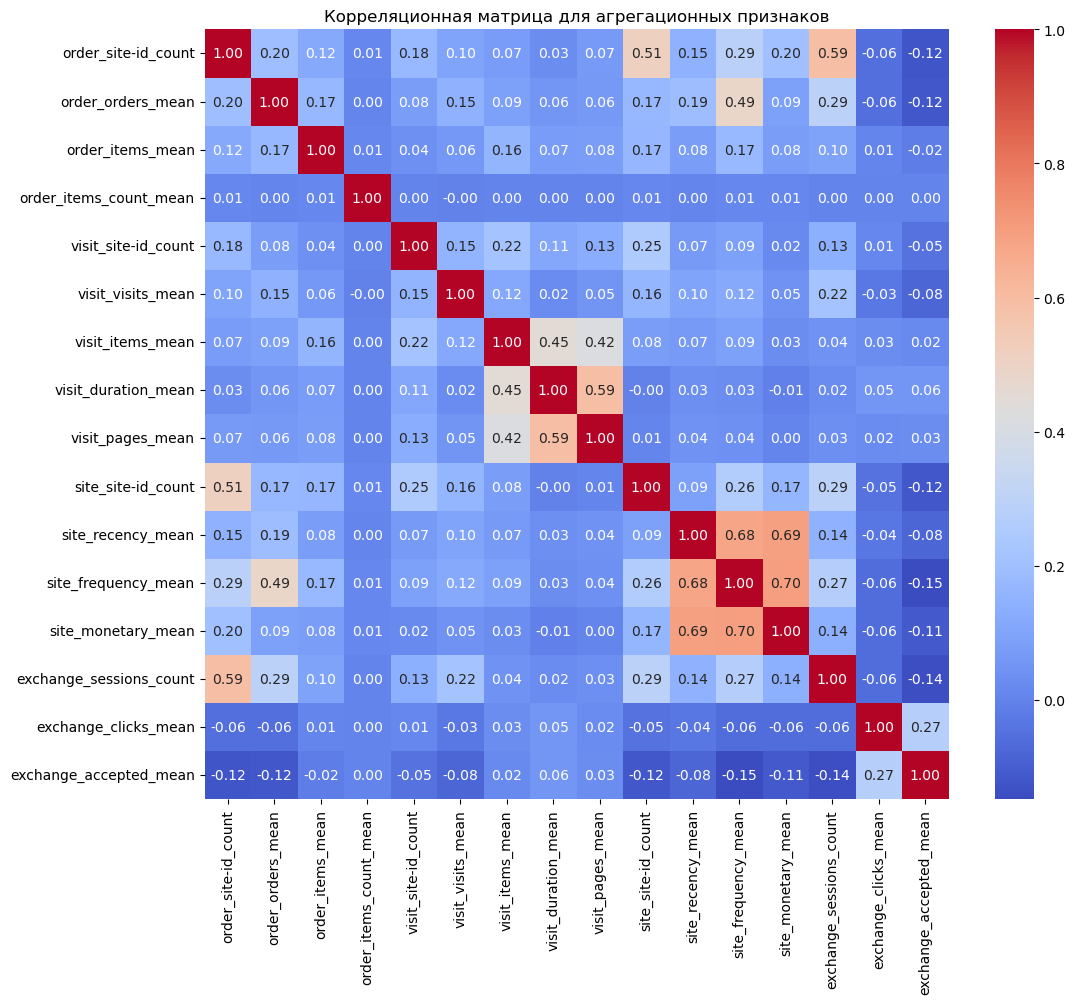

In [17]:
# Построение корреляционной матрицы для агрегационных признаков
corr_matrix = merge_df_train[col_standard].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица для агрегационных признаков")
plt.show()

In [18]:
df_train = preprocessing_df(merge_df_train, all_categories, unique_last_cats)

Количество 'Неизвестных категорий' в orders: 0
Количество 'Неизвестных категорий' в visits: 0


In [19]:
df_val = preprocessing_df(merge_df_val, all_categories, unique_last_cats)

Количество 'Неизвестных категорий' в orders: 0
Количество 'Неизвестных категорий' в visits: 0


In [20]:
X_train = df_train.drop('gender', axis=1)
y_train = df_train['gender']

In [21]:
X_val = df_val.drop('gender', axis=1)
y_val = df_val['gender']

In [22]:
X_test = preprocessing_df(merge_df_test, all_categories, unique_last_cats, target=False)

Количество 'Неизвестных категорий' в orders: 0
Количество 'Неизвестных категорий' в visits: 0


Для *XGBoost* с оптимальными параметрами `learning_rate: 0.1, max_depth: 7, n_estimators: 500`  
(подбор был GridSearch c cv=5):  
`parameters = {'max_depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [300, 500, 800]}`
- агрегационные признаки (12 шт. без count) дали accuracy 0.63
- при добавлении категорий с блока orders метрика стала 0.694 (категории векторизовали при помощи TfidfVectorizer)
- при добавлении к категориям блока orders категории блока visits метрика стала 0.724
- при смене векторизатора на MultiLabelBinarizer при тех же признаках метрика стала 0.742
- при добавлении last категорий при тех же признаках и векторизаторе MultiLabelBinarizer метрика стала 0.759
- при добавлении новых агрегациионых признаков order_site-id_count, visit_site-id_count, site_site-id_count, exchange_sessions_count метрика стала **0.768**
- добавление кол-в уникальных брендов на пользователя в блоках orders и visits не дало увеличения метрики

In [23]:
# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), col_standard)
    ],
    remainder='passthrough'  # нестандартизируемые колонки оставляем без изменений
)

# Создание пайплайна
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=500))
])

# Кросс-валидация
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Вывод результатов
print("Точность на кросс-валидации:", scores)
print("Средняя точность:", np.mean(scores))

# Обучение пайплайна на полном тренировочном наборе данных
pipeline.fit(X_train, y_train)

Точность на кросс-валидации: [0.76971547 0.76721068 0.77374662 0.7686979  0.76811084]
Средняя точность: 0.7694963015146178


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['order_site-id_count',
                                                   'order_orders_mean',
                                                   'order_items_mean',
                                                   'order_items_count_mean',
                                                   'visit_site-id_count',
                                                   'visit_visits_mean',
                                                   'visit_items_mean',
                                                   'visit_duration_mean',
                                                   'visit_pages_mean',
                                                   'site_site-id_count',
                                                   'site_recency_mean',
                                                   'site_freq...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [24]:
# Прогноз на валидационных и тестовых данных
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

In [25]:
# Расчет Confusion Matrix на валидации
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

# Вывод отчета с основными метриками классификации на валидации
classif_report = classification_report(y_val, y_pred_val)
print("\nClassification Report:")
print(classif_report)

# Расчет и вывод точности на валидации
accuracy = accuracy_score(y_val, y_pred_val)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[11176  2545]
 [ 3750  9976]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     13721
           1       0.80      0.73      0.76     13726

    accuracy                           0.77     27447
   macro avg       0.77      0.77      0.77     27447
weighted avg       0.77      0.77      0.77     27447


Accuracy: 0.77064888694575


In [26]:
# Получение имен признаков из препроцессора пайплайна
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
# Удаление префиксов из имен признаков
cleaned_feature_names = [name.split("__")[-1] for name in feature_names]

In [27]:
# Получение важности признаков из модели XGBoost
xgb_model = pipeline.named_steps['classifier']
importances = xgb_model.feature_importances_

In [28]:
importance_df = pd.DataFrame({
    'feature_name': cleaned_feature_names,
    'importance': importances
})

# Сортировка признаков по важности
importance_df = importance_df.sort_values(by='importance', ascending=False)

In [29]:
importance_df[:50]

,feature_name,importance
1838,"Косметика, парфюмерия и уход",0.050259
83,Макияж,0.016438
2811,Авто,0.009706
2153,Электроника,0.009577
2137,Уход за лицом,0.008274
3129,electronics,0.006454
3121,cosmetics,0.006415
2990,Компьютерная техника,0.006285
2107,Женская одежда,0.005878
3137,bank,0.004775


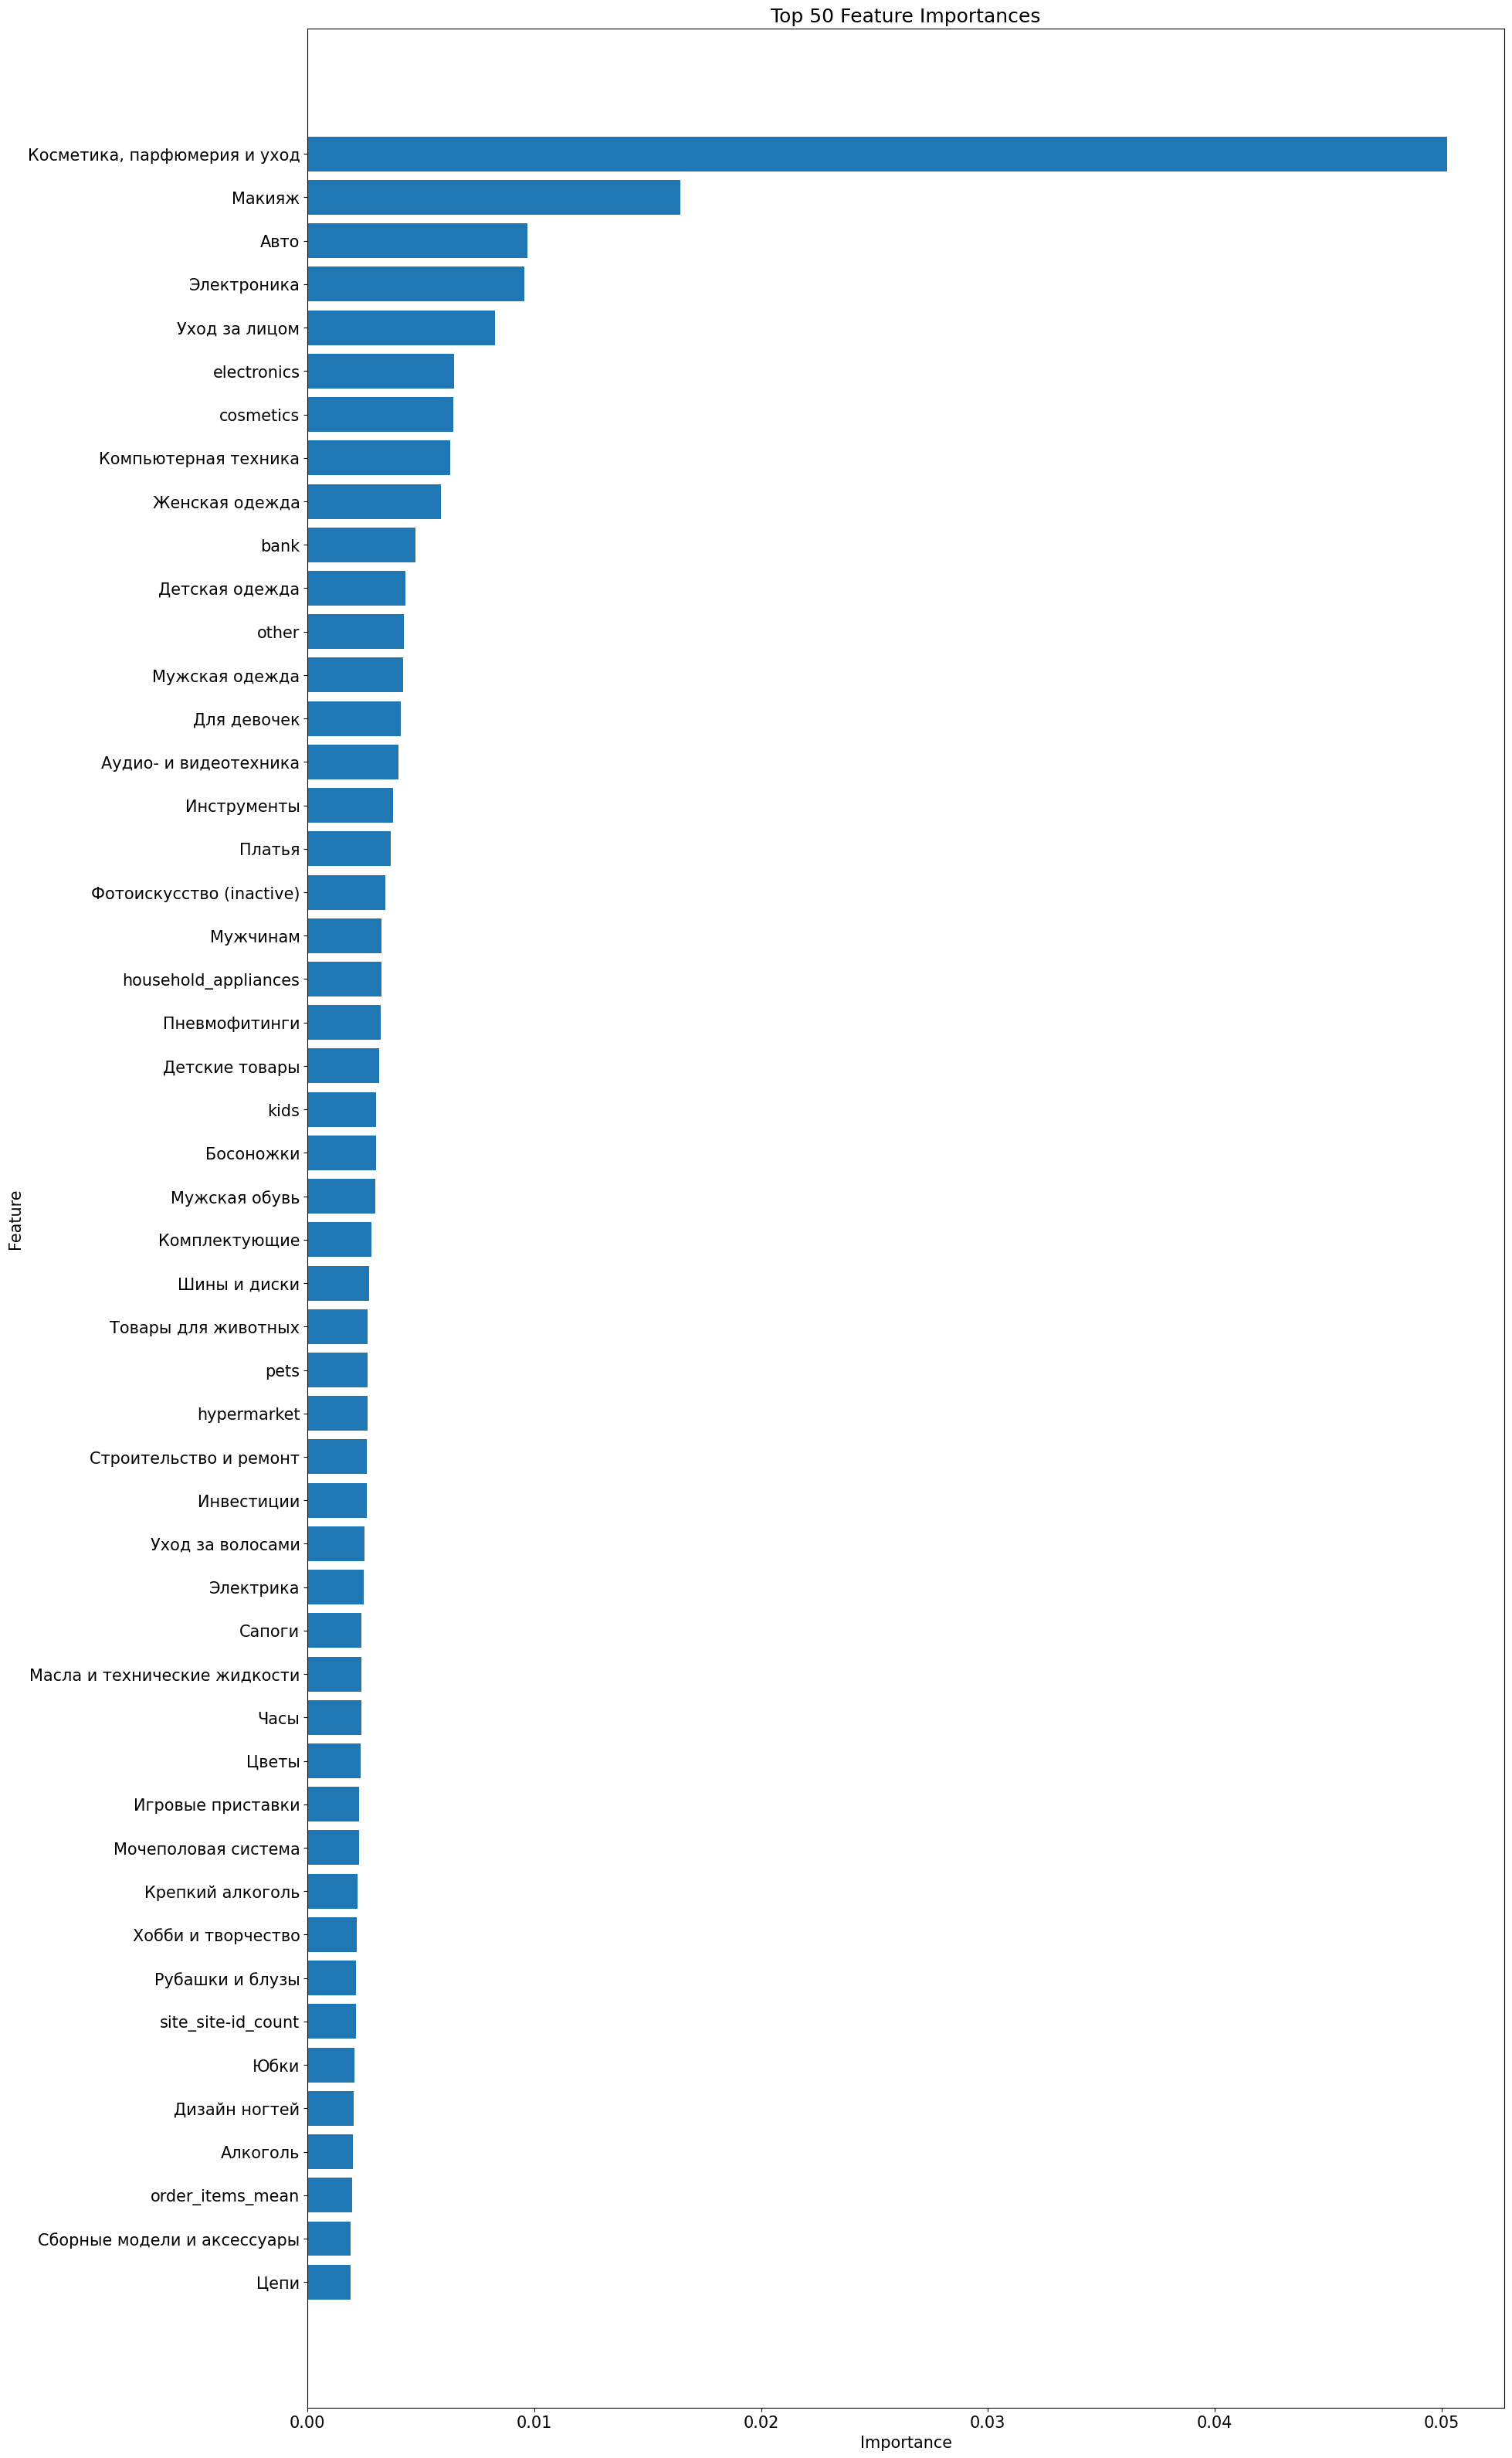

In [30]:
# Установка параметров шрифта
plt.rcParams['font.size'] = 15

# Визуализация важности признаков, первые 50
plt.figure(figsize=(20, 40))
plt.barh(importance_df['feature_name'][:50], importance_df['importance'][:50])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [31]:
# Тестовые предсказания, запись в файл
y_pred_labels = ['female' if pred == 1 else 'male' for pred in y_pred_test]
predictions_df = pd.DataFrame({
    'user_id': merge_df_test['user_id'],
    'target': y_pred_labels
})
predictions_df.to_csv('predict_test/predict_test.csv', index=False)

In [32]:
# Сохранение обученного пайплайна
joblib.dump(pipeline, 'model/trained_pipeline.pkl')

['model/trained_pipeline.pkl']

----  
*XGBoost подбор параметров и подбор параметров на других моделях*

In [348]:
# MinMaxScaler
# scaler_minmax = MinMaxScaler()
# X_train[col_standard] = scaler_minmax.fit_transform(X_train[col_standard])
# X_val[col_standard] = scaler_minmax.transform(X_val[col_standard])
# X_test[col_standard] = scaler_minmax.transform(X_test[col_standard])

In [349]:
# # Инициализация модели XGBoost
# xgb = XGBClassifier()

# # Определение параметров для GridSearchCV
# parameters = {
#     'max_depth': [7], #3, 5, 10
#     'learning_rate': [0.1], # 0.01, 0.2
#     'n_estimators': [500] # 300, 800 
# }

# # Инициализация GridSearchCV
# xgb_search = GridSearchCV(estimator=xgb, param_grid=parameters, cv=5, scoring='accuracy')

# # Обучение с использованием GridSearchCV
# xgb_search.fit(X_train, y_train)

# # Лучшие параметры и оценка
# print("Лучшие параметры:", xgb_search.best_params_)
# print("Лучшая оценка:", xgb_search.best_score_)

# best_xgb_model = xgb_search.best_estimator_

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Лучшая оценка: 0.7690501372333013


In [329]:
#col_count_cats_brands = ['order_brands', 'visit_brands']

In [330]:
# for col in col_count_cats_brands:
#     merge_df[f'{col}_count'] = merge_df[col].apply(lambda x: len(x))

In [328]:
# unique_brands = set()
# for brands in merge_df['order_brands']:
#     unique_brands.update(brands)
# for brands in merge_df['visit_brands']:
#     unique_brands.update(brands)
# unique_brands = list(unique_brands)
# unique_brands

In [20]:
#from sklearn.feature_extraction.text import TfidfVectorizer

In [290]:
# # Создание списка всех категорий для словаря векторизатора
# all_categories = set(cat_map.values())

# # Создание словаря документов для тренировочных данных
# documents = []
# for order_cats, visit_cats in zip(merge_df['order_cats'], merge_df['visit_cats']):
#     # Объединение категорий из обоих столбцов
#     combined_cats = order_cats.union(visit_cats)
#     # Преобразование ID категорий в соответствующие названия
#     document = ' '.join(cat_map.get(str(cat_id), "") for cat_id in combined_cats)
#     documents.append(document)

# # Инициализация TfidfVectorizer с заданным словарем
# vectorizer = TfidfVectorizer(vocabulary=all_categories, lowercase=False)

# # Применение TF-IDF к словарю документов
# tfidf_matrix = vectorizer.fit_transform(documents)

# print(tfidf_matrix)

In [289]:
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
# tfidf_df

In [288]:
# df = pd.concat([merge_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
# df

In [345]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df.drop('gender', axis=1), df['gender'], test_size=0.2, random_state=42)

In [148]:
# # StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train[col_standard] = scaler.fit_transform(X_train[col_standard])
# X_test[col_standard] = scaler.transform(X_test[col_standard])

In [132]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [203]:
# Прогноз на тестовых данных
#y_pred = xgb_search.predict(X_test)

In [114]:
# from sklearn.decomposition import PCA

# # Инициализация PCA
# pca = PCA(n_components=0.95)  # сохраняем 95% дисперсии

# # Применение PCA к обучающим данным
# X_train_pca = pca.fit_transform(X_train)

# # Применение трансформации PCA к тестовым данным
# X_test_pca = pca.transform(X_test)

In [127]:
# # Инициализация модели XGBoost
# xgb_pca = XGBClassifier()

# # Определение параметров для GridSearchCV
# parameters = {
#     'max_depth': [7, 10], #3, 5
#     'learning_rate': [0.1, 0.2], # 0.01
#     'n_estimators': [300, 500, 800]
# }

# # Инициализация GridSearchCV
# xgb_search_pca = GridSearchCV(estimator=xgb_pca, param_grid=parameters, cv=5, scoring='accuracy')

# # Обучение с использованием GridSearchCV
# xgb_search_pca.fit(X_train_pca, y_train)

# # Лучшие параметры и оценка
# print("Лучшие параметры:", xgb_search_pca.best_params_)
# print("Лучшая оценка:", xgb_search_pca.best_score_)

# # Прогноз на тестовых данных
# y_pred = xgb_search_pca.predict(X_test_pca)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Лучшая оценка: 0.6251711842905039


In [126]:
# import lightgbm as lgb

# # Инициализация модели LightGBM
# lgbm = lgb.LGBMClassifier()

# # Определение гиперпараметров для GridSearchCV
# # Здесь приведены лишь некоторые примеры параметров, вы можете добавить больше
# parameters = {
#     'n_estimators': [100, 200, 300, 500],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [3, 5, 7]
#     #'num_leaves': [31, 50, 100],
#     #'subsample': [0.6, 0.8, 1.0]  # Доля подвыборки для обучения каждого дерева
# }

# # GridSearchCV
# lgbm_search = GridSearchCV(lgbm, parameters, cv=5, scoring='accuracy', n_jobs=-1)

# # Обучение с использованием GridSearchCV
# lgbm_search.fit(X_train, y_train)

# # Лучшие параметры и оценка
# print("Лучшие параметры для LightGBM:", lgbm_search.best_params_)
# print("Лучшая оценка:", lgbm_search.best_score_)

# # Прогнозирование на тестовых данных
# y_pred = lgbm_search.predict(X_test)
# lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.

In [34]:
# from catboost import CatBoostClassifier

# # Инициализация модели CatBoost
# catboost = CatBoostClassifier()

# # Определение параметров для GridSearchCV
# parameters = {
#     'learning_rate': [0.01, 0.1, 0.5],  # Скорость обучения
#     'depth': [4, 6, 10],  # Глубина деревьев
#     'iterations': [100, 200, 300]  # Количество деревьев
# }

# # GridSearchCV
# catboost_search = GridSearchCV(catboost, parameters, cv=5, scoring='accuracy', n_jobs=-1, verbose=False)

# # Обучение с использованием GridSearchCV
# catboost_search.fit(X_train, y_train)

# # Лучшие параметры и оценка
# print("Лучшие параметры для CatBoost:", catboost_search.best_params_)
# print("Лучшая оценка:", catboost_search.best_score_)

# # Прогноз на тестовых данных
# y_pred = catboost_search.predict(X_test)

#Лучшие параметры для CatBoost: {'depth': 10, 'iterations': 300, 'learning_rate': 0.1}
#Лучшая оценка: 0.6937790908127454

In [134]:
# Прогноз на тестовых данных
# y_pred = catboost_search.predict(X_test)

In [156]:
# для наивного байеса
# from sklearn.preprocessing import MinMaxScaler
# scaler_minmax = MinMaxScaler()
# X_train[col_standard] = scaler_minmax.fit_transform(X_train[col_standard])
# X_test[col_standard] = scaler_minmax.transform(X_test[col_standard])

In [201]:
# from sklearn.naive_bayes import MultinomialNB
# # Инициализация модели
# mnb = MultinomialNB()

# # Определение параметров для GridSearchCV
# parameters = {
#     'alpha': [0.01, 0.1, 1, 10, 100]
# }

# # Инициализация GridSearchCV
# mnb_search = GridSearchCV(mnb, parameters, cv=5, scoring='accuracy')

# mnb_search.fit(X_train, y_train)

# print("Лучшие параметры для Multinomial Naive Bayes:", mnb_search.best_params_)
# print("Лучшая оценка:", mnb_search.best_score_)

# # Проведение предсказаний на тестовых данных
# y_pred = mnb_search.predict(X_test)

Лучшие параметры для Multinomial Naive Bayes: {'alpha': 0.1}
Лучшая оценка: 0.7094438789084254


In [205]:
# from sklearn.ensemble import RandomForestClassifier

# # Параметры для GridSearchCV
# rf_params = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [10, 20, 5]
# }

# # Инициализация модели
# rf_classifier = RandomForestClassifier()

# # GridSearchCV
# rf_grid = GridSearchCV(rf_classifier, rf_params, cv=5, scoring='accuracy')
# rf_grid.fit(X_train, y_train)

# # Лучшие параметры и оценка
# print("Лучшие параметры для случайного леса:", rf_grid.best_params_)
# print("Лучшая оценка:", rf_grid.best_score_)

# # Проведение предсказаний на тестовых данных
# y_pred = rf_grid.predict(X_test)

Лучшие параметры для случайного леса: {'max_depth': 20, 'n_estimators': 200}
Лучшая оценка: 0.7101091983409653


In [100]:
# from sklearn.neighbors import KNeighborsClassifier

# # Параметры для GridSearchCV
# knn_params = {'n_neighbors': [3, 5, 7, 10]}

# # Инициализация модели
# knn_classifier = KNeighborsClassifier()

# # GridSearchCV
# knn_grid = GridSearchCV(knn_classifier, knn_params, cv=5, scoring='accuracy')
# knn_grid.fit(X_train, y_train)

# # Лучшие параметры и оценка
# print("Лучшие параметры для KNN:", knn_grid.best_params_)
# print("Лучшая оценка:", knn_grid.best_score_)

# # Проведение предсказаний на тестовых данных
# y_pred = knn_grid.predict(X_test)

Лучшие параметры для KNN: {'n_neighbors': 10}
Лучшая оценка: 0.6000743426429616


In [33]:
# from sklearn.linear_model import LogisticRegression

# # Инициализация модели логистической регрессии
# log_reg = LogisticRegression()

# # Определение параметров для GridSearchCV
# parameters = [
# #     {
# #         'C': [0.01, 0.1, 1, 10, 100],
# #         'solver': ['liblinear', 'saga'],
# #         'penalty': ['l1']  # L1 регуляризация поддерживается 'liblinear' и 'saga'
# #     },
#     {
#         'C': [0.1, 1, 10], # 0.01, 100
#         'solver': ['newton-cg', 'liblinear'], # 'lbfgs', 'saga'
#         'penalty': ['l2']  # L2 регуляризация поддерживается всеми этими решателями
#     }
# ]

# # GridSearchCV
# lr_search = GridSearchCV(log_reg, parameters, cv=5, scoring='accuracy')

# # Обучение модели
# lr_search.fit(X_train, y_train)

# # Лучшие параметры и оценка
# print("Лучшие параметры для логистической регрессии:", lr_search.best_params_)
# print("Лучшая оценка:", lr_search.best_score_)

# # Прогноз на тестовых данных
# y_pred = lr_search.predict(X_test)

# #Лучшие параметры для логистической регрессии: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
# #Лучшая оценка: 0.6804919633624567